<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Time_Series/%EC%83%81%EC%A0%90%20%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%20%EB%A7%A4%EC%B6%9C%20%EC%98%88%EC%B8%A1%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/%EC%83%81%EC%A0%90_%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EB%A7%A4%EC%B6%9C_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theme

핀테크 기업인 ‘FUNDA(펀다)’는 상환 기간의 매출을 예측하여 신용 점수가 낮거나 담보를 가지지 못하는 우수 상점들에 금융 기회를 제공하려 합니다.

---

이번 대회에서는 2년 전 부터 2019년 2월 28일까지의 카드 거래 데이터를 이용해 2019-03-01부터 2019-05-31까지의 각 상점별 3개월 총 매출을 예측하는 것입니다.

[데이콘 : 상점 신용카드 매출 예측 경진대회](https://dacon.io/competitions/official/140472/overview/description)


[Reference 1 : [9회] 펀다 합격자 지성민 코드 및 영상 공개](https://dacon.io/competitions/official/140472/codeshare/419?page=2&dtype=recent)

[Reference 2 : 데이콘 서포터즈 2기 스터디(토) 1](https://dacon.io/competitions/official/140472/codeshare/1366?page=1&dtype=recent)

# Setting

In [18]:
!nvidia-smi

Wed Jul 27 01:09:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 라이브러리 불러오기

In [6]:
# 기본
import itertools # 자신만의 반복자를 만드는 모듈
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import joblib # 디스크 캐싱, 병렬 프로그래밍, 학습한 모델을 저장
from sklearn.metrics import make_scorer

In [7]:
# 시계열
from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta # 날짜 계산
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels
import statsmodels.api as sm  

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [112]:
# Deep Neural Network
from tensorflow.keras import layers, models
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

In [10]:
# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format
from tqdm.notebook import tqdm
import random

In [11]:
import warnings
warnings.filterwarnings("ignore")

## 예측 오차

MAE (Mean Absolute Error) : 절대평균오차

In [12]:
def mae(prediction, correct):

  prediction = np.array(prediction)
  correct = np.array(correct)

  difference = correct - prediction
  abs_val = abs(difference)

  score = abs_val.mean()

  return score

mae_score = make_scorer(mae)
mae_score

make_scorer(mae)

## 데이터 불러오기

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
train_path = '/content/drive/MyDrive/시계열/상점 신용카드 매출 예측 경진대회/funda_train.csv' 
sub_path = '/content/drive/MyDrive/시계열/상점 신용카드 매출 예측 경진대회/submission.csv'

df_train = pd.read_csv(train_path)
df_sub = pd.read_csv(sub_path)

## 데이터 확인하기

In [19]:
df_train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.14286
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.14286
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.00000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.14286
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.00000


In [20]:
df_train.shape

(6556613, 9)

In [21]:
df_train.info()
# store_id : 상점의 고유 아이디
# card_id : 사용한 카드의 고유 아이디
# card_company : 비식별화된 카드 회사
# trasacted_date : 거래 날짜
# transacted_time : 거래 시간( 시:분 )
# installment_term : 할부 개월 수( 포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다. )
# region : 상점의 지역
# type_of_business : 상점의 업종
# amount : 거래액(단위는 원이 아닙니다)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [22]:
# 각 Column 별 고유값 개수, Null 개수, type, 앞에서 부터의 5개 샘플을 확인

frame_info = [(col, # 각각의 Column
               len(df_train[col].unique()), # 고유값 개수
               df_train[col].isnull().sum(), # Null 개수
               df_train[col].dtype, # type
               df_train[col].unique()[:5]) # 앞에서 부터의 5개 샘플을 확인
               for col in df_train.columns]

df_info = pd.DataFrame(frame_info,
                       columns=['name', 'num_of_unique',
                                'num_of_nan', 'type',
                                'front5_values'])

In [23]:
df_info

,name,num_of_unique,num_of_nan,type,front5_values
0,store_id,1967,0,int64,"[0, 1, 2, 4, 5]"
1,card_id,3950001,0,int64,"[0, 1, 2, 3, 4]"
2,card_company,8,0,object,"[b, h, c, a, f]"
3,transacted_date,1003,0,object,"[2016-06-01, 2016-06-02, 2016-06-03, 2016-06-0..."
4,transacted_time,1440,0,object,"[13:13, 18:12, 18:52, 20:22, 11:06]"
5,installment_term,34,0,int64,"[0, 2, 3, 60, 4]"
6,region,181,2042766,object,"[nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]"
7,type_of_business,146,3952609,object,"[기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배..."
8,amount,30551,0,float64,"[1857.142857142857, 857.1428571428571, 2000.0,..."


# 데이터 전처리

## 시계열 분석을 위해 date를 index로 변환

In [24]:
df_train = df_train.set_index('transacted_date')

In [25]:
df_train.head()

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.14286
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.14286
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.00000
2016-06-01,0,3,a,20:22,0,NaN,기타 미용업,7857.14286
2016-06-02,0,4,c,11:06,0,NaN,기타 미용업,2000.00000


## 새로운 Columns 생성


* 'store_id', 'region', 'type_of_business' 기존과 동일
* day_of_week : 각 요일을 나타내는 숫자, 월요일은 0 일요일은 6
* business_day : working day 여부, 1이면 working day 0이면 주말
* num_of_pay : 일 결제 건수, 'card_id'의 count로 생성
* num_of_revisit : 단골 방문 횟수, 'card_id'의 value 중 count가 2보다 큰(3 이상) value의 결제 건수
* installment_term : 일 총 할부 개월 수, 기존 installment_term의 합
* amount : 일 매출 액, 기존 amount의 합

In [26]:
def preprocessing_day(DataFrame):
  
  # 새로운 데이터 프레임 생성
  new_df = pd.DataFrame()


  for store in tqdm(DataFrame.store_id.unique()):

    # 데이터 셋에서 상점의 고유 아이디 별 데이터 추출
    unique_store = DataFrame[DataFrame.store_id == store]
    unique_store.index = pd.to_datetime(unique_store.index)

    # '일 (day)'별로 사용한 카드의 고유 아이디별로 거래 횟수 확인
    count_cols = unique_store['card_id'].resample(rule='d').count().rename('num_of_pay')


    # 단골 방문 횟수, 'card_id'의 value 중 count가 2보다 큰(3 이상) value의 결제 건수
    count_visit = unique_store.card_id.value_counts().reset_index()

    cond_visit = (count_visit['card_id'] > 2)
    
    revisit_idx = count_visit.loc[cond_visit]["index"].values

    df_revisit = unique_store[unique_store.card_id.isin(revisit_idx)]
    df_revisit.index = pd.to_datetime(df_revisit.index)

    revisit_ct = df_revisit[df_revisit.card_id.isin(revisit_idx)].card_id.resample(rule='d').count().rename('num_of_revisit')

    # 할부 개월수와 매출액은 일 단위로 합
    sum_cols = unique_store[['installment_term', 'amount']].resample(rule='d').sum()

    # 새로운 Columns 병합
    preprocessing_df = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)

    # 기존 Columns 불러오기
    preprocessing_df.insert(0, 'store_id', store)
    preprocessing_df.insert(4, 'region', unique_store[unique_store.store_id == store].region.unique()[0])
    preprocessing_df.insert(5, 'type_of_business', unique_store[unique_store.store_id == store].type_of_business.unique()[0])

    # 모두 병합
    new_df = pd.concat([new_df, preprocessing_df], axis=0)

  # 각 요일을 나타내는 숫자, 월요일은 0 일요일은 6
  new_df.insert(1, 'day_of_week', new_df.index.dayofweek)

  # working day 여부, 1이면 working day 0이면 주말
  new_df.insert(2, 'business_day', new_df.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)

  # 단골 방문이 없는 경우 0으로 대체
  new_df.num_of_revisit.fillna(0, inplace=True)

  return new_df

In [27]:
day_df = preprocessing_day(df_train)

  0%|          | 0/1967 [00:00<?, ?it/s]

## 전처리된 데이터 확인하기

In [28]:
day_df.head()

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714
2016-06-04,0,5,0,7,3.00000,0,NaN,기타 미용업,31714.28571
2016-06-05,0,6,0,3,3.00000,0,NaN,기타 미용업,10428.57143


In [29]:
day_df.isnull().sum()

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

In [30]:
df_corr = day_df.corr()
df_corr

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.00000,-0.00004,0.00001,0.04237,0.00806,-0.01218,-0.01835
day_of_week,-0.00004,1.00000,-0.79052,0.01672,-0.03869,-0.01395,-0.02150
business_day,0.00001,-0.79052,1.00000,-0.00460,0.05721,0.01530,0.02947
num_of_pay,0.04237,0.01672,-0.00460,1.00000,0.70112,0.09414,0.26525
num_of_revisit,0.00806,-0.03869,0.05721,0.70112,1.00000,0.07113,0.26067
installment_term,-0.01218,-0.01395,0.01530,0.09414,0.07113,1.00000,0.26750
amount,-0.01835,-0.02150,0.02947,0.26525,0.26067,0.26750,1.00000


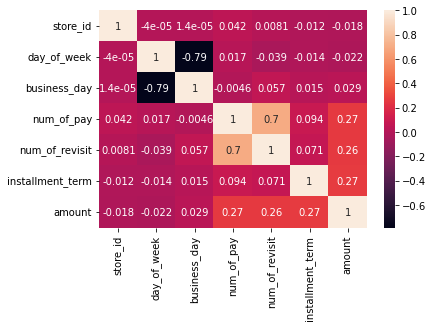

In [31]:
sns.heatmap(df_corr, annot=True)

## Modeling을 위해 Month 단위로 변환

* 예측해야 하는 범위는 3개월인데 데이터는 시간 단위로 나뉘어져 있음 
* month 주기로 resampling 후 forecast 범위를 3개월로 지정하여 해결

In [32]:
def preprocessing_month(day_df):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for store in tqdm(day_df.store_id.unique()):
        df_set = day_df[day_df.store_id == store]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        # date_range 함수를 이용하면 start와 end 날짜 사이의 모든 날짜를 담은 변수를 생성할 수 있음
        # concat 함수로 이전 이후 한 달 row를 추가로 붙임
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)),
                                  end=(df_set.index[0] - relativedelta(months=1)))
        
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)),
                                 end=(df_set.index[-1] + relativedelta(months=1)))
        
        df_set = pd.concat([pd.DataFrame(index=prev_date),
                            df_set,
                            pd.DataFrame(index=add_date)],
                            axis=0)
        
        # strftime 함수는 datetime 형식의 모양을 변경해주는 것 (연-월 단위)
        # 첫 달과 마지막 달에 1을 넣어둠
        df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
        df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1

        # 매출액이 0이 아닌 데이터에 대해 요일 카운트와 business day합을 넣음
        tot_day = df_set[df_set.amount != 0].day_of_week.resample(rule='m').count().rename('real_tot_day')
        business = df_set[df_set.amount != 0].business_day.resample(rule='m').sum().rename('real_business_day')

        # 이전 이후 달 삭제(drop 함수 이용해 인덱스 기준으로 삭제)
        business = business.drop([business.index[0], business.index[-1]], axis=0)
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)

        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

        df.insert(0, 'store_id', store)
        df.insert(6, 'region', df_set.region.values[0])
        df.insert(7, 'type_of_business', df_set.type_of_business.values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [33]:
month_df = preprocessing_month(day_df)

  0%|          | 0/1967 [00:00<?, ?it/s]

In [34]:
month_df.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [35]:
# 전체 row 개수 대비 컬럼별 결측값 row 개수 비율 확인
print("rate of 'region' :" , month_df.region.isnull().sum() / len(month_df))
print("rate of 'type_of_business' :" , month_df.type_of_business.isnull().sum() / len(month_df))

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


In [36]:
month_df = month_df.drop(['region', 'type_of_business'], axis=1)
month_df.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [37]:
month_df.shape

(60915, 7)

In [38]:
month_df.describe()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
count,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000
mean,1050.48428,21.06964,15.89620,107.63544,40.01136,14.87540,1123187.83063
std,617.48320,7.75343,5.63154,101.24413,43.88133,33.42161,1753567.15171
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-514285.71429
25%,515.00000,16.00000,12.00000,32.00000,11.00000,0.00000,339642.85714
50%,1039.00000,23.00000,17.00000,73.00000,26.00000,3.00000,710714.28571
75%,1587.00000,28.00000,21.00000,159.00000,54.00000,14.00000,1344650.00000
max,2136.00000,31.00000,23.00000,2186.00000,2154.00000,1125.00000,61429316.14286


# EDA

In [31]:
# 무작위 상점 ID 추출

random.seed(10)

def make_random(count):
  random_list = []

  for _ in range(count):

    num = random.randrange(0, month_df.store_id.unique()[-1])

    if num in random_list:
      num = random.randrange(0, 10)
    
    random_list.append(num)
    
  return random_list

## target 변수의 대칭성(정규성) 확인

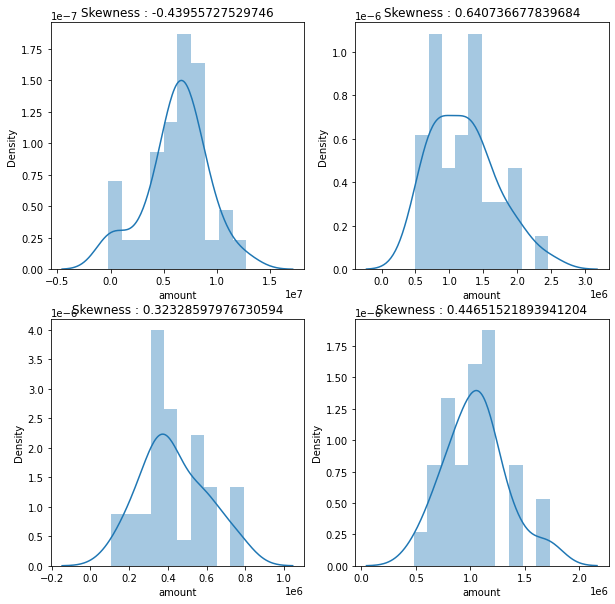

In [32]:
random.seed(1208)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))

for i, z in zip(make_random(4), [[0,0], [0,1], [1,0], [1,1]]):
    sns.distplot(month_df[month_df.store_id == i].amount,
                 ax=ax[z[0], z[-1]],
                 bins=10).set(title='Skewness : '+str(month_df[month_df.store_id == i].amount.skew()))

## 각 변수의 value 분포 시각화

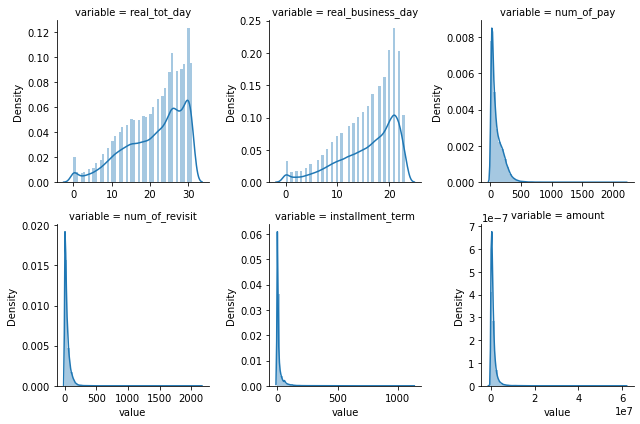

In [33]:
# melt 함수를 이용해 컬럼을 row 단위로 변경해줌 (powerBI의 열피벗해제)
# 상점 ID 빼고 전부 melt
# melt하면 컬럼 6개가 variable이라는 컬럼의 값으로 들어가고, 각 컬럼의 값들은 value라는 컬럼의 값으로 들어감
f = pd.melt(month_df, value_vars=month_df.columns[1:])
g = sns.FacetGrid(f, col="variable",  col_wrap=3,
                  sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

## 같은 기간 동안 여러 상점 매출의 추이 및 스케일 확인(Store_id : 0~10)


각 store_id별로 다른 trend와 seasonality, scale을 가지는 것을 확인

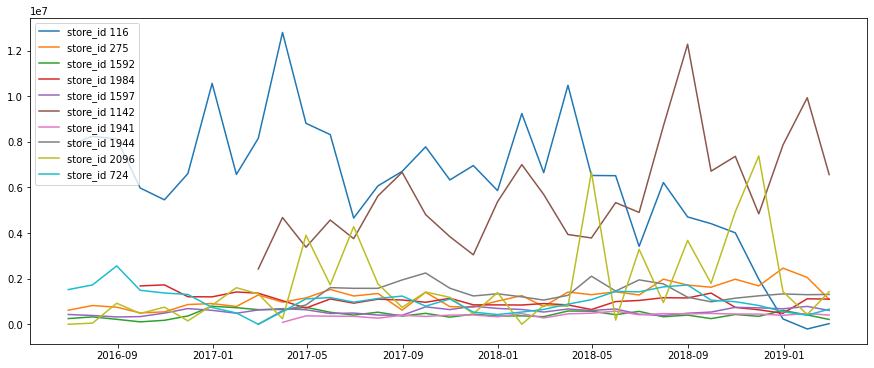

In [34]:
random.seed(1208)
plt.figure(figsize=(15, 6))
for i in make_random(10):
    plt.plot(month_df[month_df.store_id == i].index, month_df[month_df.store_id == i].amount, label='store_id {}'.format(i))
plt.legend()

## 다른변수들이 'amount'와 같은 pattern을 가지는 지 확인

In [35]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
    df_set = data_frame[data_frame.store_id == store_num]
    
    fig, ax1 = plt.subplots(figsize=(10, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))
        

    fig.tight_layout()
    plt.show()

### 상점 ID별로 월 매출 액, 총 영업일, 월 결제 건수 비교

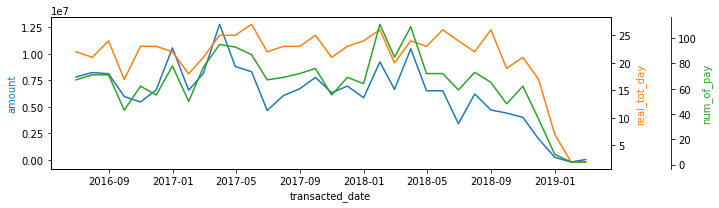

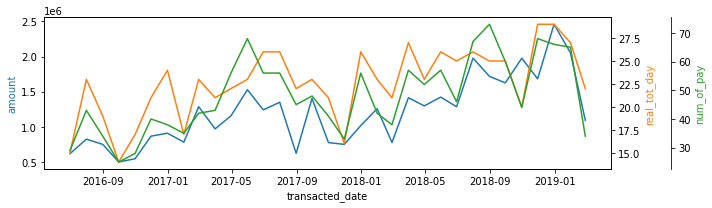

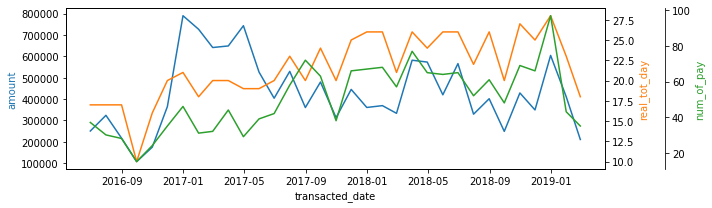

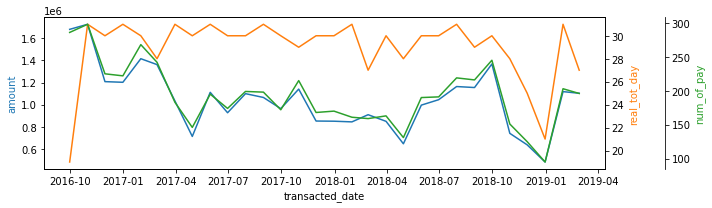

In [36]:
random.seed(1208)

for i in make_random(4):
    plot_model_graph(month_df, i,
                     'transacted_date',
                     ['amount', # 월 매출 액
                      'real_tot_day', # 총 영업일
                      'num_of_pay']) # 월 결제 건수

### 상점 ID별로 월 매출 액, 총 주중 근무일, 단골 방문 횟수 비교

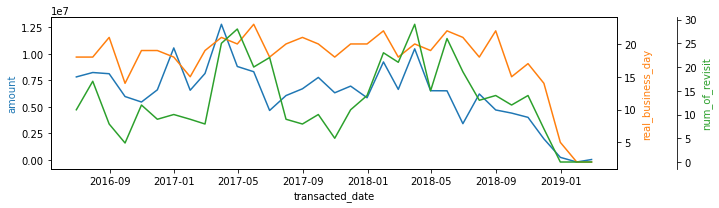

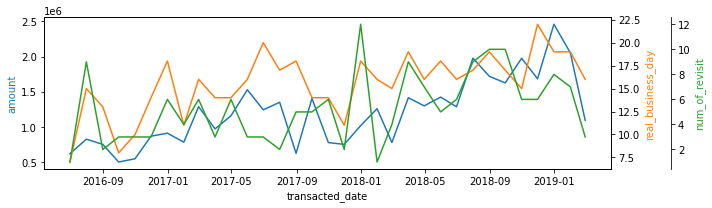

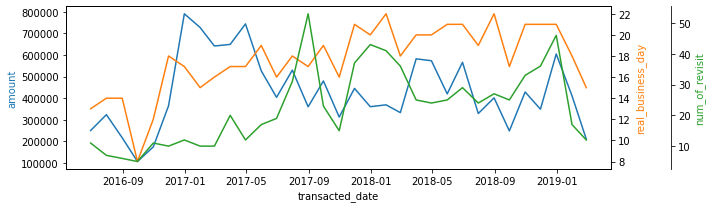

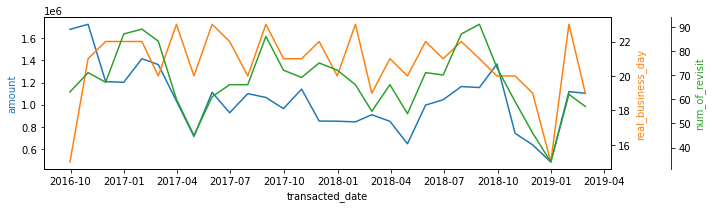

In [37]:
random.seed(1208)

for i in make_random(4):
    plot_model_graph(month_df, i,
                     'transacted_date',
                     ['amount', # 월 매출 액
                      'real_business_day', # 총 주중 근무일
                      'num_of_revisit']) # 단골 방문 횟수

### 상점 ID별로 월 매출 액, 할부 개월 수 비교 

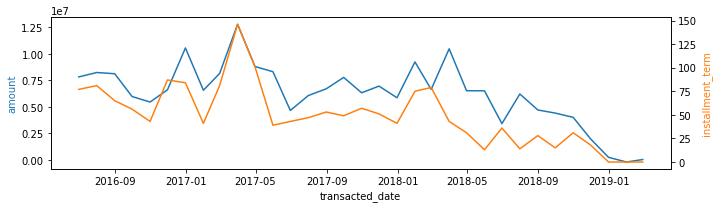

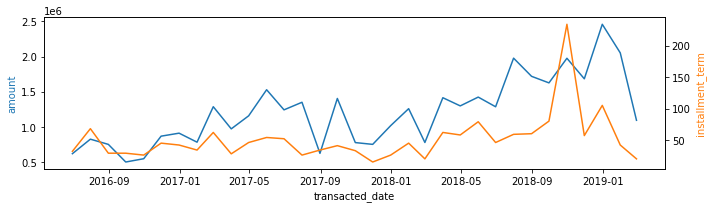

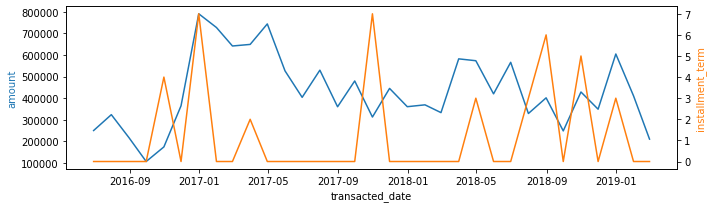

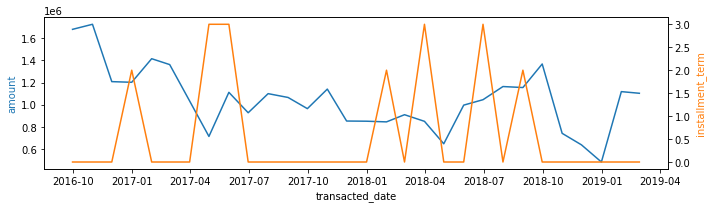

In [38]:
random.seed(1208)

for i in make_random(4):
    plot_model_graph(month_df, i, 
                     'transacted_date', 
                     ['amount', # 월 매출 액
                      'installment_term']) # 할부 개월 수

# Modeling

## Time Series

### Simple Moving Average

* 단순이동평균은 특정 기간 동안의 data를 단순 평균하여 계산한다. 따라서 그 기간 동안의 data를 대표하는 값이 이동평균 안에는 그 동안의 data 움직임을 포함하고 있다.
* 이동평균의 특징인 지연(lag)이 발생하며 수학적으로 n/2 시간 만큼의 지연이 발생한다.
* 단순이동평균은 모든 데이터의 중요도를 동일하다고 간주한다.

In [39]:
def make_sma_arr(window_num):

  ma_arr = np.array([])

  for i in month_df.store_id.unique():

    df_set = month_df[month_df.store_id == i]
    ma_arr = np.concatenate((ma_arr,
                             df_set.amount.rolling(window=window_num).mean().values))
    
  return ma_arr

In [40]:
sma_month = month_df.copy()

sma_month.insert(7, 'amount_2ma', make_sma_arr(2))
sma_month.insert(8, 'amount_3ma', make_sma_arr(3))
sma_month.insert(9, 'amount_6ma', make_sma_arr(6))

In [41]:
sma_month.head(7)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_2ma,amount_3ma,amount_6ma
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,NaN,NaN,NaN
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,876000.00000,NaN,NaN
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,938285.71429,874523.80952,NaN
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286,884714.28571,924809.52381,NaN
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143,866642.85714,868285.71429,NaN
2016-11-30,0,23,15.00000,132.00000,93.00000,21.00000,697000.00000,766214.28571,810095.23810,842309.52381
2016-12-31,0,27,18.00000,145.00000,103.00000,11.00000,761857.14286,729428.57143,764761.90476,844785.71429


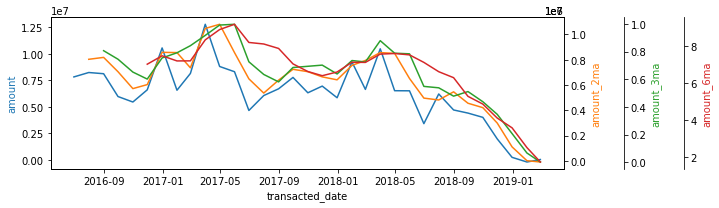

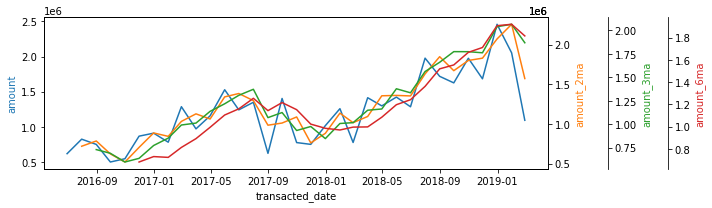

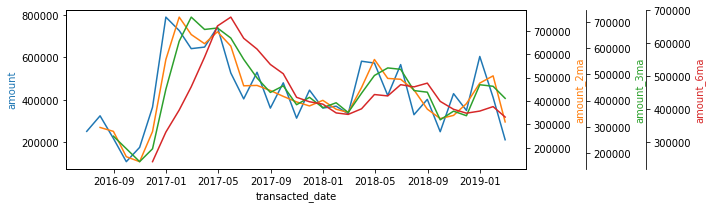

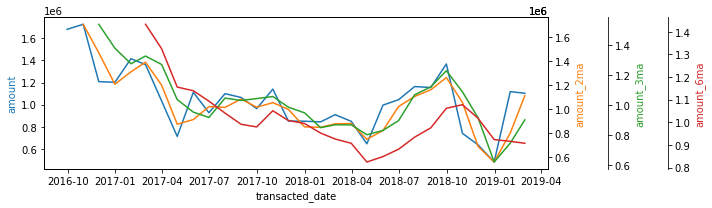

In [42]:
random.seed(1208)

for i in make_random(4):
    plot_model_graph(sma_month, i,
                     'transacted_date',
                     ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

In [43]:
print("2 winodw SMA MAE Score : ", mae(sma_month.amount_2ma.fillna(0), sma_month.amount.values))
print("3 window SMA MAE Score : ", mae(sma_month.amount_3ma.fillna(0), sma_month.amount.values))
print("6 window SMA MAE Score : ", mae(sma_month.amount_6ma.fillna(0), sma_month.amount.values))


2 winodw SMA MAE Score :  180687.25906004856
3 window SMA MAE Score :  251607.4552831229
6 window SMA MAE Score :  387465.0993765708


In [44]:
def make_minus_rolling(data_frame, rolling_num):
    def minus_shift_rolling(df_num, num):
        a = np.average(df_num.values[-num:])
        b = np.average(np.append(df_set.values[-(num-1):], a))
        if num > 2:
            c = np.average(np.append(np.append(df_set.values[-(num-2):], a), b))
        else:
            c = np.average((a, b))
        return np.sum((a, b, c))

    minus_rolling_arr = np.array([])
    for i in data_frame.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        minus_rolling_arr = np.concatenate((minus_rolling_arr, np.array([minus_shift_rolling(df_set, rolling_num)])))
        
    df_sub['amount'] = minus_rolling_arr
    
    return df_sub

In [45]:
for i in range(2, 5):
    df_rolling = make_minus_rolling(month_df, i)
    df_rolling.to_csv(f'SMA_{i}_rolling.csv', index=False)

In [46]:
SMA_2 = pd.read_csv('/content/SMA_2_rolling.csv')

데이콘 Public Score : 836184.506518688

In [47]:
SMA_2

,store_id,amount
0,0,1734375.00000
1,1,312000.00000
2,2,1390446.42857
3,4,2717250.00000
4,5,767464.28571
...,...,...
1962,2132,1824589.28571
1963,2133,312535.71429
1964,2134,546857.14286
1965,2135,1278107.14286


### Exponential Moving Average

지수이동평균은 가중이동평균 중의 하나로 단순이동평균보다 최근의 데이터에 높은 가중치를 부여하는 방법

In [48]:
def make_ewm_arr(data_frame, span_num):

    arr_ewm = np.array([])

    for i in data_frame.store_id.unique():

        df_set = data_frame[data_frame.store_id == i]

        # pandas에 내장된 ewm 패키지를 이용하면 지수이동평균을 쉽게 이용할 수 있음
        # 마지막에 .mean()을 해줘야 평균값이 월별로 각각 잘 계산됨
        arr_ewm = np.concatenate((arr_ewm, df_set.amount.ewm(span=span_num).mean().values))
    
    return arr_ewm

In [49]:
ewm_month = month_df.copy()

ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(month_df, 3))
ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(month_df, 6))

In [50]:
ewm_month.head(7)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_3ewm,amount_6ewm
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,747000.00000,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,919000.00000,897500.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,891897.95918,885844.03670
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286,895076.19048,890484.23423
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143,864290.32258,871161.23374
2016-11-30,0,23,15.00000,132.00000,93.00000,21.00000,697000.00000,779317.46032,813780.07136
2016-12-31,0,27,18.00000,145.00000,103.00000,11.00000,761857.14286,770518.56018,797390.12474


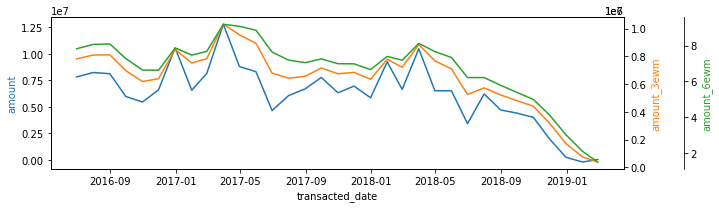

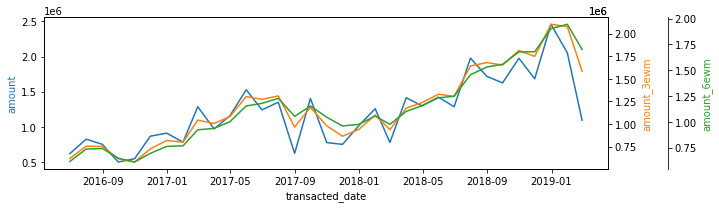

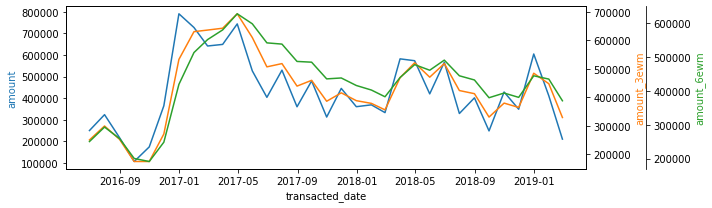

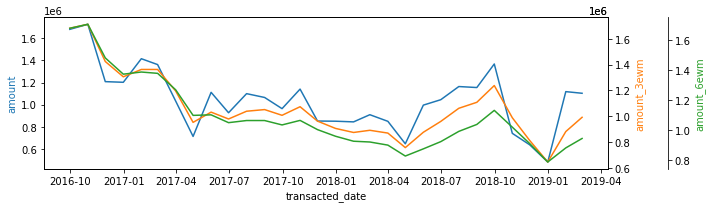

In [51]:
random.seed(1208)

for i in make_random(4):
    plot_model_graph(ewm_month, i, 'transacted_date', ['amount', 'amount_3ewm', 'amount_6ewm'])

In [52]:
print("3 N EWM MAE Score : ", mae(ewm_month.amount_3ewm, sma_month.amount.values))
print("6 N EWM MAE Score : ", mae(ewm_month.amount_6ewm, sma_month.amount.values))

3 N EWM MAE Score :  134855.11946915495
6 N EWM MAE Score :  193447.63093078104


In [53]:
def make_wma_sub(data_frame, span_num):
    
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    wma_sub = np.array([])

    for i in month_df['store_id'].unique():
        df_set = pd.DataFrame(data_frame[data_frame['store_id'] == i]['amount'])
        wma_train = pd.concat([df_set, concat_3mon], axis=0)

        num_sub = np.array([wma_train['amount'].ewm(span=span_num).mean()['2019-03':].sum()])

        wma_sub = np.concatenate((wma_sub, num_sub))
        
    df_wma_sub = pd.DataFrame({'store_id' : df_sub['store_id'], 'amount' : wma_sub})
    
    
    return df_wma_sub

In [54]:
for i in range(2, 7):
    wma_sub = make_wma_sub(month_df, i)
    wma_sub.to_csv(f'wma_{i}_span.csv', index=False)

In [55]:
WMA_5 = pd.read_csv('/content/wma_5_span.csv')

데이콘 Public Score : 767498.551420

In [56]:
WMA_5

,store_id,amount
0,0,1977776.26836
1,1,289928.61359
2,2,1259294.60063
3,4,2675065.05006
4,5,941204.04432
...,...,...
1962,2132,1889129.45636
1963,2133,402815.23869
1964,2134,375166.36924
1965,2135,1506346.06053


### Exponential Smoothing (지수평활법)

* Simple Exponential Smoothing
* Holt's Exponential Smoothing
* Holt-Winter's Exponential Smoothing

#### Simple Exponential Smoothing

* trend나 seasonality 반영을 하지 못함
* level 정도만 수평선으로 나옴

데이터 분할

In [57]:
df_set = month_df[month_df.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

모델 학습 및 예측

In [58]:
# 모델 불러오기
ses_model = SimpleExpSmoothing(train.amount)

# 모델 학습
ses_result = ses_model.fit()

# 모델 예측
ses_pred = ses_result.forecast(len(test))

In [59]:
print("store_id 0 mean value : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, ses_pred))

store_id 0 mean value :  732559.7402597402
MAE Score of test : 78235.9098256067


In [43]:
def plot_train_test_pred_graph(trainset, testset, pred):
    plt.figure(figsize=(15,3))
    plt.plot(trainset.amount, label='train')
    plt.plot(testset.amount, label='test')
    plt.plot(testset.index, pred, label='prediction')
    plt.legend()
    plt.show()

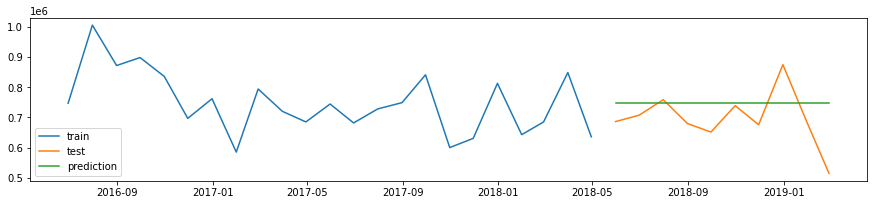

In [61]:
plot_train_test_pred_graph(train, test, ses_pred)

In [62]:
ses_pred_arr = np.array([])

for i in tqdm(month_df.store_id.unique()):
    df_set = month_df[month_df.store_id == i]
    
    ses_model = SimpleExpSmoothing(df_set.amount)
    ses_result = ses_model.fit()
    ses_pred = ses_result.forecast(3)
    
    ses_pred_arr = np.concatenate((ses_pred_arr, np.array([ses_pred.sum()])))

  0%|          | 0/1967 [00:00<?, ?it/s]

In [63]:
df_ses_sub = pd.DataFrame({'store_id' : df_sub['store_id'], 'amount' : ses_pred_arr})

In [64]:
df_ses_sub.to_csv('ses.csv', index=False)

In [65]:
df_ses_sub = pd.read_csv('/content/ses.csv')

데이콘 Public Score : 817565.9575205083

In [66]:
df_ses_sub

,store_id,amount
0,0,2071341.61354
1,1,287871.57326
2,2,1270950.22776
3,4,2676061.20669
4,5,715765.56180
...,...,...
1962,2132,2190878.14401
1963,2133,348857.14286
1964,2134,425306.17821
1965,2135,1633115.51484


#### Holt's Exponential Smoothing

* trend로 데이터를 예측하기 위해 Simple Exponential Smoothing에서 확장한 것이다.
* 예측을 위한 식 외에 level smoothing을 위한 식과 trend smoothing을 위한 식이 포함된다
* 생성된 예측은 선형적으로 나타나기 때문에 예측 범위가 멀어질 수록 over-forecast 되는 경향이 있다.

In [67]:
df_set = month_df[month_df.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

holt_model = Holt(np.array(train.amount))
holt_result = holt_model.fit()
holt_pred = holt_result.forecast(len(test))

Mean value of store_id 0 :  732559.7402597402
MAE Score of test : 104762.75933861049


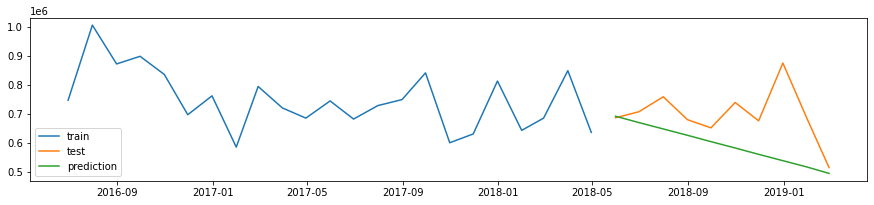

In [68]:
print("Mean value of store_id 0 : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, holt_pred))

plot_train_test_pred_graph(train, test, holt_pred)

In [69]:
holt_pred_arr = np.array([])

for i in tqdm(month_df.store_id.unique()):
  
    df_set = month_df[month_df.store_id == i]
    
    holt_model = Holt(np.array(df_set.amount))
    holt_result = holt_model.fit()
    holt_pred = holt_result.forecast(3)
    
    holt_pred_arr = np.concatenate((holt_pred_arr, np.array([holt_pred.sum()])))

  0%|          | 0/1967 [00:00<?, ?it/s]

In [70]:
df_holt_sub = pd.DataFrame({'store_id' : df_sub['store_id'], 'amount' : holt_pred_arr})

In [71]:
df_holt_sub.to_csv('holt.csv', index=False)

In [72]:
df_holt_sub = pd.read_csv('/content/holt.csv')

데이콘 Public Score : 916740.7957870358

In [73]:
df_holt_sub

,store_id,amount
0,0,1209081.81753
1,1,285083.61962
2,2,1333354.02296
3,4,2721639.30907
4,5,702503.40367
...,...,...
1962,2132,1590940.36308
1963,2133,354035.95499
1964,2134,280943.79109
1965,2135,688246.83713


#### Holt-Winter's Exponential Smoothing


* Holt-Winter's 방법은 seasonality를 반영하기 위해 Holt's 방법에서 확장된 것이다.
* Holt-Winter's 방법은 예측식과 3개의 smoothing 식으로 구성되어 있다.
  * level에 대한 식  𝑙𝑡 
  * trend에 대한 식  𝑏−𝑡 
  * seasonal에 대한 요소  𝑠𝑡 
  * smoothing parameter에 해당하는  𝛼 ,  𝛽∗ ,  𝛾 
  * seasonality의 빈도를 나타내기 위한  𝑚 
* seasonal이 변화하는 형태에 따라 두 가지 방법이 있다.
  * additive : seasonal의 변화가 일정하게 지속될 때
  * multiplicative : seasonal의 변화가 level에 비례적일 때

In [74]:
df_set = month_df[month_df.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

In [75]:
# 최적값을 찾기 위한 기준
es_score = 1000000000
best_period = 0

# 각 store_id 최적의 seasonal period를 찾기 위한 탐색
for p in range(2,(len(train)//2) + 1):

    try:
        # ExponentialSmoothing 패키지에서 trend와 seasonal을 모두 add로 설정하면 추세변동 계절변동을 모두 고려하게 됨
        es_model = ExponentialSmoothing(np.array(train.amount), seasonal_periods=p, trend='add', seasonal='add')
        es_result = es_model.fit()
        es_pred = es_result.forecast(len(test))
        
        # 추정 결과를 검정한 mae값이 기준값(혹은 이전 최적값)보다 작은 경우 이를 계속 업데이트
        if es_score > mae(test.amount, es_pred):
            es_score = mae(test.amount, es_pred)
            best_period = p

    except:
        continue

Mean value of store_id 0 : 732559.7402597402
MAE Score of test : 63279.994236023354
Best seasonal period : 4


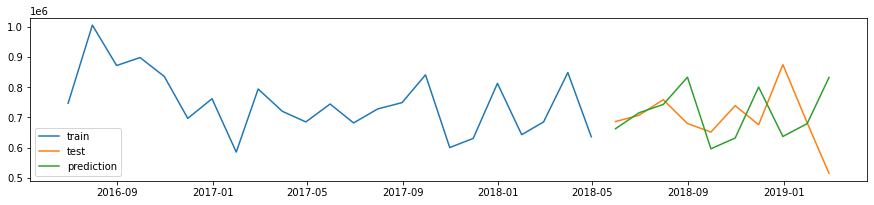

In [76]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", es_score)
print("Best seasonal period :", best_period)

plot_train_test_pred_graph(train, test, es_pred)

In [77]:
holt_winters_arr = np.array([])

# 모든 store_id별로 위의 코드를 반복
for i in tqdm(month_df.store_id.unique()):
    df_set = month_df[month_df.store_id == i]

    size = int(len(df_set) * 0.7)
    train = df_set[:size]
    test = df_set[size:]
    
    # 최적값을 찾기 위한 기준
    es_score = 900000000
    best_period = 0

    # 각 store_id 최적의 seasonal period를 찾기 위한 탐색
    for p in range(2,(len(train)//2) + 1):
      
        try:
            es_model = ExponentialSmoothing(np.array(train.amount),seasonal_periods=p, trend='add', seasonal='add')
            es_result = es_model.fit()
            es_pred = es_result.forecast(len(test))

            if es_score > mae(test.amount, es_pred):
                es_score = mae(test.amount, es_pred)
                best_period = p
        except:
            continue
    
    # 최적의 parameter을 이용한 3개월 예측과 sum
    set_es_model = ExponentialSmoothing(np.array(df_set.amount), seasonal_periods=best_period, trend='add', seasonal='add')
    set_es_result = set_es_model.fit()
    set_es_pred = set_es_result.forecast(3)
    
    holt_winters_arr = np.concatenate((holt_winters_arr, np.array([set_es_pred.sum()])))

  0%|          | 0/1967 [00:00<?, ?it/s]

In [78]:
df_holt_winter_sub = pd.DataFrame({'store_id' : df_sub['store_id'], 'amount' : holt_winters_arr})

In [79]:
df_holt_winter_sub.to_csv('holt_winter.csv', index=False)

In [80]:
df_holt_winter_sub = pd.read_csv('/content/holt_winter.csv')

데이콘 Public Score : 979248.8578214531

In [81]:
df_holt_winter_sub

,store_id,amount
0,0,2090250.21358
1,1,262152.70543
2,2,1645788.15428
3,4,2587723.79113
4,5,572196.31157
...,...,...
1962,2132,1787478.69665
1963,2133,602483.91939
1964,2134,53946.29743
1965,2135,1838310.20897


### ARMA

* ARMA(p,q) 모형은 AR(p) 모형과 MA(q) 모형의 특징을 모두 가지는 모형이다. 즉, p개의 자기 자신의 과거값과 q개의 과거 백색 잡음의 선형 조합으로 현재의 값이 정해지는 모형이다.
𝑌𝑡=−𝜙1𝑌𝑡−1−𝜙2𝑌𝑡−2−⋯−𝜙𝑝𝑌𝑡−𝑝+𝜖𝑡+𝜃1𝜖𝑡−1+𝜃2𝜖𝑡−2+⋯+𝜃𝑞𝜖𝑡−𝑞
 
* 많은 store_id들이  |𝜙|<1 의 AR 정상상태(stationary) 조건에 맞지 않아 1 이상의 p 값을 적용할 수 없다.
* 따라서 차분(difference)을 이용해 비정상상태(non-stationary)의 설명이 가능한 ARIMA를 추가로 진행한다.

In [82]:
df_set = month_df[month_df.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

In [83]:
set_arma = sm.tsa.ARMA(train.amount, (0, 2))
set_result = set_arma.fit()

set_output = set_result.forecast(len(test))
set_pred = set_output[0]

Mean value of store_id 0 : 732559.7402597402
MAE Score of test : 80938.78069569408


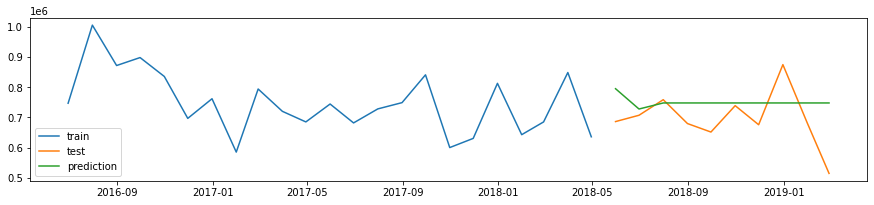

In [84]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, set_pred))

plot_train_test_pred_graph(train, test, set_pred)

In [85]:
arma_arr = np.array([])

for i in tqdm(month_df.store_id.unique()):

    df_set = month_df[month_df.store_id == i]
    
    # (0, 2) 모델로 진행을 하다 error가 발생하면 (0, 1)모델로 진행
    try:
        arma_model = sm.tsa.ARMA(df_set.amount, (0, 2))
        arma_result = arma_model.fit()
    except:
        arma_model = sm.tsa.ARMA(df_set.amount, (0, 1))
        arma_result = arma_model.fit()
        
    output = arma_result.forecast(3)
    
    arma_arr = np.concatenate((arma_arr, np.array([output[0].sum()])))

  0%|          | 0/1967 [00:00<?, ?it/s]

In [86]:
df_arma_0_2_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : arma_arr})

In [87]:
df_arma_0_2_sub['amount'].isnull().sum()

7

In [88]:
# (0, 2)로 진행했지만 nan값이 발생하는 경우 확인
df_null = df_arma_0_2_sub[df_arma_0_2_sub.amount.isnull()]

In [89]:
# nan값이 발생한 store_id는 (0, 1) 모델로 재진행
for i in tqdm(df_null.store_id):

    df_set = month_df[month_df.store_id == i]

    arma_model = sm.tsa.ARMA(df_set.amount, (0, 1))
    arma_result = arma_model.fit()

    output = arma_result.forecast(3)

    idx_num = df_arma_0_2_sub[df_arma_0_2_sub.store_id == i].index.values[0]
    df_arma_0_2_sub[idx_num:idx_num + 1] = output[0].sum()

  0%|          | 0/7 [00:00<?, ?it/s]

In [90]:
df_arma_0_2_sub['store_id'] = df_sub['store_id']

In [91]:
df_arma_0_2_sub.to_csv('ARMA.csv', index=False)

In [92]:
df_arma_0_2_sub = pd.read_csv('/content/ARMA.csv')

데이콘 Public Score : 981671.6282313891

In [93]:
df_arma_0_2_sub

,store_id,amount
0,0,2177513.58660
1,1,321798.19904
2,2,1239893.12905
3,4,2709574.00023
4,5,879853.50492
...,...,...
1962,2132,2245484.69001
1963,2133,859174.19928
1964,2134,818809.36797
1965,2135,1641076.51639


### ARIMA(Autoregressive Integrated Moving Average)

* ARIMA 모델은  𝑌𝑡 을 차분(difference)한 결과로 만들어지 시계열  ∇𝑌𝑡=𝑌𝑡−𝑌𝑡−1 이 ARMA 모형을 따르면 원래의 시계열  𝑌𝑡 를 ARIMA 모형이라고 한다.
* 만약  𝑑 번 차분한 후예야 시계열  ∇𝑑𝑌𝑡 가 ARMA(p,q) 모형을 따른다면 적분 차수가(order of integration)가 d인 ARIMA 모형으로 ARIMA(p, d, q)로 표기한다.
* q=0인 경우에는 ARI(p,d), q=0인 경우에는 IMA(d,q)로 표기한다.
* p, d, q의 조합을 탐색하며 최적 parameter를 찾고 기준은 fit에 저장되어 있는 AIC(Akaike's Information Criterion)을 기준으로 한다. 다음과 같은 식을 가지며 작을 수록 좋은 모형이다.
          𝐴𝐼𝐶=−2𝑙𝑜𝑔(𝐿𝑖𝑘𝑒𝑙𝑖ℎ𝑜𝑜𝑑)+2𝐾
 
  * 𝑘  : 모델의 추정된 parameter의 갯수
  * 𝐿𝑖𝑘𝑒𝑙𝑖ℎ𝑜𝑜𝑑  : 모델의 likelihoood function의 최댓값

In [46]:
p = list(range(0, 6))
d = [0, 1, 2]
q = list(range(0, 6))

pdq = list(itertools.product(p, d, q))

In [47]:
df_set = month_df[month_df.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

In [48]:
best_score = 9000000
best_param = 0

for param in tqdm(pdq):

    try:

        arima_model = ARIMA(train.amount.values, order=param)
        result = arima_model.fit()

        if result.aic < best_score:
            best_score = result.aic
            best_param = param

    except:
        continue

  0%|          | 0/108 [00:00<?, ?it/s]

In [49]:
set_arima = ARIMA(df_set.amount.values, order=best_param)
set_result = set_arima.fit()
set_pred = set_result.forecast(len(test))[0]

Mean value of store_id 0 : 732559.7402597402
AIC Score of test : 557.6623816920737
Best parameter of (p, d, q):  (2, 2, 1)


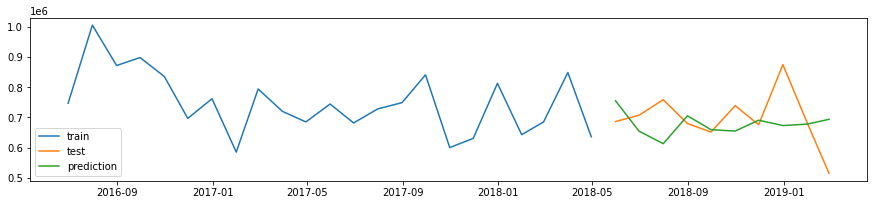

In [50]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("AIC Score of test :", best_score)
print("Best parameter of (p, d, q): ",best_param)

plot_train_test_pred_graph(train, test, set_pred)

In [69]:
arima_pred_arr = np.array([])

# 전부 돌리면 오래걸려서 50개만 예측
for i in tqdm(month_df.store_id.unique()[:10]):

    df_set = month_df[month_df.store_id == i]

    best_score = 10000000000
    best_param = 0

    for param in pdq:

        try:
            arima_model = ARIMA(df_set.amount.values, order=param)
            result = arima_model.fit()

            # 최적 parameter는 fit에 저장되어 있는 AIC값을 기준으로 선정 한다.
            if result.aic < best_score:
                best_score = result.aic
                best_param = param

        except:
            continue
    
    arima_model = ARIMA(df_set.amount.values, order=best_param)
    arima_result = arima_model.fit()
    arima_pred = arima_result.forecast(3)[0]

    arima_pred_arr = np.concatenate((arima_pred_arr, np.array([arima_pred.sum()])))

  0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
arima_sum_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : arima_pred_arr})

ValueError: ignored

In [ ]:
arima_sum_sub.to_csv('ARIMA.csv', index=False)

In [ ]:
arima_sum_sub = pd.read_csv('/content/ARIMA.csv')

### Facebook Prophet

* prophet은 페이스북에서 개발한 시계열 예측 패키지이다. ARIMA와 같이 확률론적이고 이론적인 모형이 아닌 몇가지 경험적 규칙(heuristic rule)을 사용하는 단순 회귀 모형이지만 단기적 예측에서는 큰 문제 없이 사용할 수 있다.
* prophet은 다음 순서로 시계열에 대한 회귀분석 모형을 만든다.
시간 데이터의 각종 특징을 임베딩하여 계절성 추정을 한다.
나머지 데이터는 구간별 선형회귀(piecewise linear regression) 분석을 한다. 구간 구분점을 change point라고 한다.
* prophet을 사용하기 위해서는 ds, y 2개의 column만을 정의하여 사용해야 한다.
* prophet은 다음과 같이 Growth, Seasonality, Holidays로 구성되어 있다.
                                    𝑦(𝑡)=𝑔(𝑡)+𝑠(𝑡)+ℎ(𝑡)+𝑒𝑟𝑟𝑜𝑟
 
  * g(t) : Growth, 'linear'와 'logistic'으로 구분되어 있다.
  * s(t) : Seasonality
  * h(t) : Holidays, 계절성을 가지진 않지만 전체 추이에 영향을 주는 이벤트를 의미하며 이벤트의 효과는 독립적이라 가정한다.

In [56]:
df_set = month_df[month_df.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

In [65]:
# prophet은 ds와 y 두 개의 column으로만 진행
df_prophet = pd.DataFrame({'ds' : train.index, 'y' : train.amount}).reset_index(drop=True)

# 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' 등을 사용하지 않고 default인 'linear' 사용
prophet_model = Prophet()
result = prophet_model.fit(df_prophet)

# prophet_test = pd.DataFrame(test.index).rename(columns={'0' : 'ds'})
prophet_test.columns = ['ds']
prophet_pred_df = result.predict(prophet_test)
prophet_pred = prophet_pred_df.yhat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


Mean value of store_id 0 : 732559.7402597402
MAE Score of test : 80553.73059130632


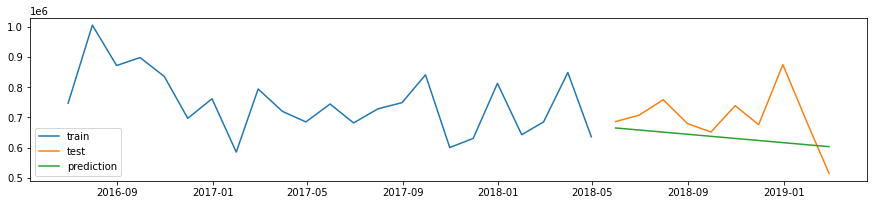

In [66]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, prophet_pred))

plot_train_test_pred_graph(train, test, prophet_pred)

In [68]:
front_arr = np.array([])

for i in tqdm(month_df.store_id.unique()[:10]):

    df_set = month_df[month_df.store_id == i]

    # 각 store_id를 prophet에 맞는 dataframe의 형태로 생성('ds', 'y' columns)
    df_prophet = pd.DataFrame({'ds' : df_set.index, 'y' : df_set.amount}).reset_index(drop=True)
    
    # 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' growth를 사용하지 않고 default인 'linear' growth 사용
    prophet_model = Prophet() 
    result = prophet_model.fit(df_prophet)

    # 예측할 date를 prophet 예측에 맞는 dataframe 형태로 생성
    extend_date = pd.date_range(start=df_set.index[-1], end=dt.strptime('2019-05-31', "%Y-%m-%d"), freq='m')[1:]
    extend_future = pd.DataFrame(extend_date).rename(columns = {0 : 'ds'})
    forecast = result.predict(extend_future)
    
    front_arr = np.concatenate((front_arr, np.array([forecast.yhat[:3].sum()])))

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
df_prophet_front_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : front_arr})

In [ ]:
df_prophet_front_sub.to_csv('prophet.csv', index=False)

In [ ]:
df_prophet_front_sub = pd.read_csv('/content/prophet.csv')

### Result

In [87]:
Time_Series_model = {'Model':["Simple Moving Average(3 rolling)",
                              "Exponential Moving Average(5 span)",
                              "Simple Exponential Smoothing",
                              "Holt's Exponential Smoothing",
                              "Holt-Winter's Exponential Smoothing",
                              "ARMA model",
                              "ARIMA model",
                              "Facebook prophet"],

                     'Score':[831158.397180,
                              767498.551420,
                              818205.822450,
                              926470.756080,
                              962259.599880,
                              984368.752690,
                              1080182.482790,
                              1221173.032530]}

Time_Series_model = pd.DataFrame(Time_Series_model)
Time_Series_model = Time_Series_model.sort_values(by='Score', ascending=True)

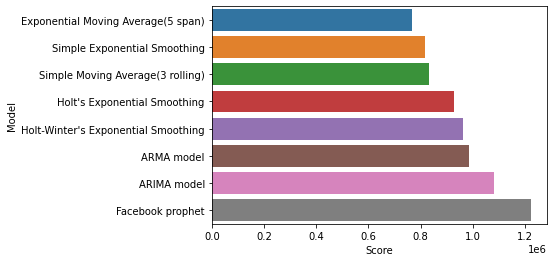

In [88]:
sns.barplot(data=Time_Series_model, y='Model', x='Score')

## Regression

### 데이터 전처리

#### index를 'year', 'month' 변수로 변환

* 회귀분석을 하기 위해서는 모든 변수들의 값이 numeric 해야 한다.
* date의 각 year, month를 변수로 변환

In [95]:
df_month_reg = month_df.copy()

df_month_reg.insert(1, 'year',df_month_reg.index.year)
df_month_reg.insert(2, 'month',df_month_reg.index.month)

df_month_reg.reset_index(drop=True, inplace=True)

In [77]:
df_month_reg.head()

,store_id,year,month,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
0,0,2016,6,25,17.00000,145.00000,77.00000,13.00000,747000.00000
1,0,2016,7,26,16.00000,178.00000,105.00000,24.00000,1005000.00000
2,0,2016,8,24,16.00000,171.00000,97.00000,69.00000,871571.42857
3,0,2016,9,25,19.00000,160.00000,103.00000,15.00000,897857.14286
4,0,2016,10,26,16.00000,167.00000,115.00000,9.00000,835428.57143


#### 예측해야할 각 'store_id'의 2019-03 ~ 2019-05월 대한 data frame 생성


* 회귀변수는 단 하나의 값만 예측하기 때문에 2019/03~2019/05에 대한 각 'amount'를 예측하고 sum한다.
* 입력할 수 있는 'store_id'와 'year', 'month'를 제외한 변수들의 값은 0으로 대체한다.

In [78]:
df_problem = pd.DataFrame()

for i in tqdm(df_month_reg.store_id.unique()):

    df_add = pd.DataFrame({'store_id' : i, 'year' : 2019, 'month' : [3, 4, 5]},
                          columns=df_month_reg.columns)
    
    df_problem = pd.concat([df_problem, df_add], axis=0)

df_problem.fillna(0, inplace=True)

  0%|          | 0/1967 [00:00<?, ?it/s]

### Regression을 위해 사용할 변수들 설정

* 'store_id', 'year', 'month' 이외 변수들의 값을 예측하여 채우는 version1
* 'store_id', 'year', 'month'만 사용하는 version2

In [99]:
reg_models = [LinearRegression(),
              Ridge(),
              Lasso(),
              ElasticNet(),
              GradientBoostingRegressor(),
              SVR(),
              XGBRegressor()]

reg_model_names = ["LinearRegression",
                    "Ridge",
                    "Lasso",
                    "ElasticNet",
                    "GradientBoositng",
                    "SupportVector",
                    "XGBoost"]

In [81]:
# 각 columns values 예측을 위해 사용할 알고리즘들의 score 확인
def predict_columns(data_frame, x_cols, y_col):

    size = int(len(data_frame) * 0.7)
    train = data_frame[:size]
    test = data_frame[size:]

    Regression_Model = {'Model':reg_model_names,
                        'Score':[]}

    for i in tqdm(range(len(reg_models))):

        reg = reg_models[i].fit(train[x_cols], train[y_col])
        pred = reg_models[i].predict(test[x_cols])

        print('{} : {}'.format(reg_model_names[i], mae(test[y_col], pred.astype(int))))

        Regression_Model['Score'].append(mae(test[y_col], pred.astype(int)))

    Regression_Model = pd.DataFrame(Regression_Model).sort_values(by='Score', ascending=False)

    return Regression_Model

In [82]:
df_Regression_Model = predict_columns(df_month_reg, ['store_id', 'year', 'month'], 'real_tot_day')

  0%|          | 0/7 [00:00<?, ?it/s]

LinearRegression : 6.522079343365253
Ridge : 6.522079343365253
Lasso : 6.528426812585499
ElasticNet : 6.528426812585499
GradientBoositng : 6.738659370725034
SupportVector : 9.021231190150479
[02:09:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost : 6.697783857729138


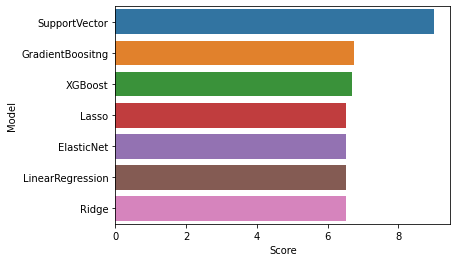

In [84]:
sns.barplot(data=df_Regression_Model, x='Score', y='Model')

In [85]:
size = int(len(df_month_reg) * 0.7)
train = df_month_reg[:size]
test = df_month_reg[size:]

In [86]:
svr_model = SVR().fit(train[['store_id', 'year', 'month']],
                      train['real_tot_day'])

svr_pred = svr_model.predict(df_problem[['store_id', 'year', 'month']])

df_problem.real_tot_day = svr_pred.astype(int)

In [89]:
svr_model = SVR().fit(train[['store_id', 'year', 'month',
                             'real_tot_day', 'real_business_day', 'num_of_pay', 'num_of_revisit']],
                      train['installment_term'])

svr_pred = svr_model.predict(df_problem[['store_id', 'year', 'month',
                                         'real_tot_day', 'real_business_day',
                                         'num_of_pay', 'num_of_revisit']])

df_problem.installment_term = svr_pred.astype(int)

In [90]:
linear_model = LinearRegression().fit(train[['store_id', 'year', 'month',
                                             'real_tot_day']],
                                      train['real_business_day'])

linear_pred = linear_model.predict(df_problem[['store_id', 'year', 'month',
                                               'real_tot_day']])

df_problem.real_business_day = linear_pred.astype(int)

In [91]:
linear_model = LinearRegression().fit(train[['store_id', 'year', 'month',
                                             'real_tot_day', 'real_business_day']],
                                      train['num_of_pay'])

linear_pred = linear_model.predict(df_problem[['store_id', 'year', 'month',
                                               'real_tot_day', 'real_business_day']])

df_problem.num_of_pay = linear_pred.astype(int)

In [92]:
linear_model = LinearRegression().fit(train[['store_id', 'year', 'month',
                                             'real_tot_day', 'real_business_day', 'num_of_pay']],
                                      train['num_of_revisit'])

linear_pred = linear_model.predict(df_problem[['store_id', 'year', 'month',
                                               'real_tot_day', 'real_business_day', 'num_of_pay']])

df_problem.num_of_revisit = linear_pred.astype(int)

In [93]:
df_problem.reset_index(drop=True, inplace=True)
df_problem.isnull().sum()

store_id             0
year                 0
month                0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [94]:
print(len(df_month_reg))
print(len(train))
print(len(test))
print(len(df_problem))

60915
42640
18275
5901


### Regression Models 확인


* LinearRegression, Ridge, Lasso, ElasticNet, GradientBoostingRegression, SupportVectorRegression, XGBRregressor 사용

In [52]:
cv = KFold(10, shuffle=True, random_state=0)

In [96]:
size = int(len(df_month_reg) * 0.7)
train = df_month_reg[:size]
test = df_month_reg[size:]

In [97]:
month_reg_x = df_month_reg.drop(['amount'], axis=1)
month_reg_y = df_month_reg['amount']

In [100]:
for i in tqdm(range(len(reg_models))):

    full_cols = -cross_val_score(reg_models[i],
                                 month_reg_x, month_reg_y,
                                 scoring="neg_mean_absolute_error",
                                 cv=cv)
    
    certain_cols = -cross_val_score(reg_models[i],
                                    month_reg_x[['store_id', 'year', 'month']],
                                    month_reg_y,
                                    scoring="neg_mean_absolute_error", 
                                    cv=cv)
    
    print("{} : {} / {}".format(reg_model_names[i], full_cols.mean(), certain_cols.mean()))

  0%|          | 0/7 [00:00<?, ?it/s]

LinearRegression : 678067.9921790466 / 860995.5630422148
Ridge : 678067.986002912 / 860995.5620794104
Lasso : 678067.9687164166 / 860995.5564583564
ElasticNet : 678224.7782547597 / 860983.2014218643
GradientBoositng : 583578.4246617939 / 779611.4582705365
SupportVector : 776749.3559754833 / 776779.3087005987
[03:16:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:16:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:16:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:16:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:16:12] WARNING: /workspace/src/objective/regression

## LSTM 

* LSTM은 RNN(Recurrent Neural Neetwork)의 일종이다. RNN은 학습을 할 때, 현재 입력값 뿐만 아니라 이전에 들어온 입력 값을 함께 고려하기 때문에 시계열 데이터를 학습하기에 적합하다. 신경망 중간에 있는 hidden layer의 결과값들이 다시 입력값으로 들어가기 때문에 순환(Recurrent) 신경망(Neural Network)이라는 이름이 붙었다.

* 그러나 RNN은 만약 데이터가 너무 길어져 이를 표현하는 신경망이 깊어져야만 할 경우 문제가 발생한다. RNN은 역전파(Backpropagation)라는 방법을 통해 학습하는데, 그래디언트가 너무 작아져 학습이 잘 안되는 문제(Vanishing Gradient Problem)가 발생할 수 있다. 이 문제를 해결하기 위해 LSTM이 만들어졌다.

* LSTM은 cell state라는 개념을 도입하여 그 내부에 있는 gate들을 통해 어떤 정보를 기억하고 어떤 정보를 버릴지 추가적인 학습을 가능하게 한다. 이를 통해 RNN이 가진 문제를 해결할 수 있다.

* 신경망을 빠르고 수월하게 학습시키려면 데이터들의 범위를 -1에서 1사이의 값으로 정규화(normalization)시켜야 한다.
* 𝑝0  의 값이 0인 경우를 대비하여 아래와 같은 식으로 normalization 진행
                                         𝑛𝑖=((𝑝𝑖+1)/(𝑝0+1))−1
 
* 예측한 값을 원래의 값으로 되돌릴 때는 아래와 같은 denormalization 수식을 사용한다.
                                         𝑝𝑖=(𝑝0+1)(𝑛𝑖+1)−1

### 정규화

In [156]:
df_month_dl = month_df.copy()

normalized_arr = np.array([])

for i in tqdm(df_month_dl.store_id.unique()):

    df_set = df_month_dl[df_month_dl.store_id == i].amount.values
    set_arr = np.array([(float(i + 1) / float(df_set[0] + 1))-1 for i in df_set])
    normalized_arr = np.concatenate((normalized_arr, set_arr))

df_month_dl.insert(7, 'normalize', normalized_arr)

  0%|          | 0/1967 [00:00<?, ?it/s]

In [157]:
df_month_dl.head()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,normalize
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,0.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,0.34538
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,0.16676
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286,0.20195
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143,0.11838


### 데이터 전처리

In [158]:
df_set = df_month_dl[df_month_dl.store_id == 0]

dl_x = df_set.index.values
dl_y = df_set.normalize

In [159]:
size = int(len(df_set) * 0.7)

x_train = dl_x[:size]
y_train = dl_y[:size]
x_test = dl_x[size:]
y_test = dl_y[size:]

In [160]:
x_train = x_train.reshape(len(x_train), 1)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

x_test = x_test.reshape(len(x_test), 1)
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [161]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

### 모델 생성

In [162]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))

model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True))

model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True))

model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50))

model.add(Dropout(0.2))

# Adding the output layer

model.add(Dense(units = 1))

In [163]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [164]:
model.fit(x_train, y_train, epochs=100, validation_split=0.05, verbose=1)

Epoch 1/100
1/1 [==============================] - 31s 31s/step - loss: 0.0184 - val_loss: 0.0203
Epoch 2/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0183 - val_loss: 0.0203
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0185 - val_loss: 0.0203
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0185 - val_loss: 0.0203
Epoch 5/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0185 - val_loss: 0.0203
Epoch 6/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0183 - val_loss: 0.0203
Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0181 - val_loss: 0.0203
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0185 - val_loss: 0.0203
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0182 - val_loss: 0.0202
Epoch 10/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0183 - val_loss: 0.0202
Epoch 11/100
1/1 [=

In [165]:
lstm_pred = model.predict(x_test)

df_lstm_test = pd.DataFrame([((df_set.amount[0] + 1) * (i + 1) - 1) for i in y_test.values], columns=['amount'], index=y_test.index)
df_lstm_pred = pd.DataFrame([((df_set.amount[0] + 1) * (i + 1) - 1)[0] for i in lstm_pred], columns=['amount'])

Mean value of store_id 0 : 732559.7402597402
MAE score of test : 78497.17900468875


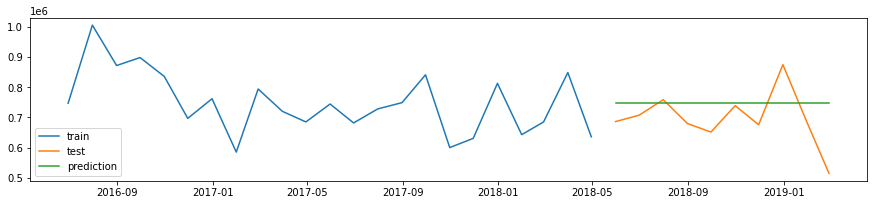

In [166]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE score of test :", mae(df_lstm_test, df_lstm_pred))

plot_train_test_pred_graph(df_set[:size], df_lstm_test, df_lstm_pred)

In [ ]:
lstm_sub_arr = np.array([])

for i in tqdm(df_month_dl.store_id.unique()):
    df_set = df_month_dl[df_month_dl.store_id == i]

    dl_x = df_set.index.values
    dl_y = df_set.normalize

    dl_x = dl_x.reshape(len(dl_x), 1)
    dl_x = np.reshape(dl_x, (dl_x.shape[0], 1, dl_x.shape[1]))

    dl_x = dl_x.astype(np.float32)
    dl_y = dl_y.astype(np.float32)

    # 모델 생성
    model = Sequential()

    #Adding the first LSTM layer and some Dropout regularisation

    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))

    model.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation

    model.add(LSTM(units = 50, return_sequences = True))

    model.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation

    model.add(LSTM(units = 50, return_sequences = True))

    model.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation

    model.add(LSTM(units = 50))

    model.add(Dropout(0.2))

    # Adding the output layer

    model.add(Dense(units = 1))

    model.compile(loss='mean_squared_error', optimizer='adam')

  # 모델 학습
    model.fit(dl_x, dl_y, epochs=20, validation_split=0.05, verbose=0)

    target_date = pd.date_range(start=df_set.index[-1], end=dt.strptime('2019-05-31', "%Y-%m-%d"), freq='m')[1:]
    target_date = target_date.values.reshape(len(target_date), 1)
    target_date = np.reshape(target_date, (target_date.shape[0], 1, target_date.shape[1]))

    target_date = target_date.astype(np.float32)

    lstm_pred = model.predict(target_date)

    # print("Value of store_id {} prediction :".format(i),lstm_pred.reshape(len(lstm_pred),))
    pred_sum = sum([((df_set.amount[0] + 1) * (i + 1) - 1)[0] for i in lstm_pred])
    lstm_sub_arr = np.concatenate((lstm_sub_arr, np.array([pred_sum])))

  0%|          | 0/1967 [00:00<?, ?it/s]